In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
data = pd.read_csv('creditcard.csv')

In [3]:
# Data Preprocessing
def preprocess_data(df):
    X = df.drop(['Class', 'Time'], axis=1)
    y = df['Class'].values  # Convert to NumPy array for later indexing
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y, scaler

In [4]:
# Balance dataset using undersampling (NumPy-compatible)
def balance_dataset(X, y):
    fraud_indices = np.where(y == 1)[0]
    non_fraud_indices = np.where(y == 0)[0]
    
    np.random.seed(42)
    sampled_non_fraud_indices = np.random.choice(non_fraud_indices, size=len(fraud_indices), replace=False)
    
    combined_indices = np.concatenate([fraud_indices, sampled_non_fraud_indices])
    np.random.shuffle(combined_indices)
    
    X_balanced = X[combined_indices]
    y_balanced = y[combined_indices]
    
    return X_balanced, y_balanced

In [5]:
# Anomaly Detection
def apply_anomaly_detection(X):
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    iso_pred = iso_forest.fit_predict(X)
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    lof_pred = lof.fit_predict(X)
    return iso_pred, lof_pred

In [6]:
# Train XGBoost
def train_xgboost(X_train, y_train):
    model = XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        random_state=42,
        eval_metric='auc'
    )
    model.fit(X_train, y_train)
    return model

In [7]:
# Plot ROC Curve
def plot_roc_curve(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
# Main Execution
def main():
    # Preprocess data
    X_scaled, y, scaler = preprocess_data(data)
    
    # Balance dataset
    X_balanced, y_balanced = balance_dataset(X_scaled, y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced, test_size=0.2, random_state=42
    )
    
    # Apply anomaly detection (optional)
    iso_pred, lof_pred = apply_anomaly_detection(X_train)
    
    # Train XGBoost
    model = train_xgboost(X_train, y_train)
    
    # Save model and scaler
    joblib.dump(model, 'xgboost_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Evaluation
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve
    plot_roc_curve(y_test, y_pred_proba)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        93
           1       0.98      0.96      0.97       104

    accuracy                           0.97       197
   macro avg       0.97      0.97      0.97       197
weighted avg       0.97      0.97      0.97       197



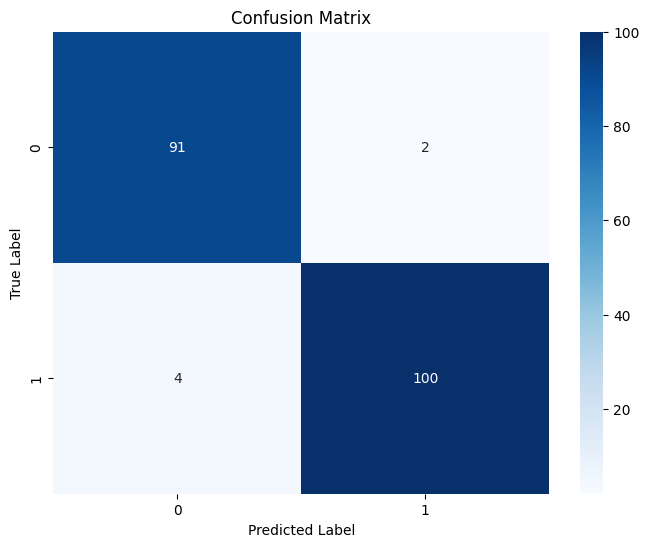

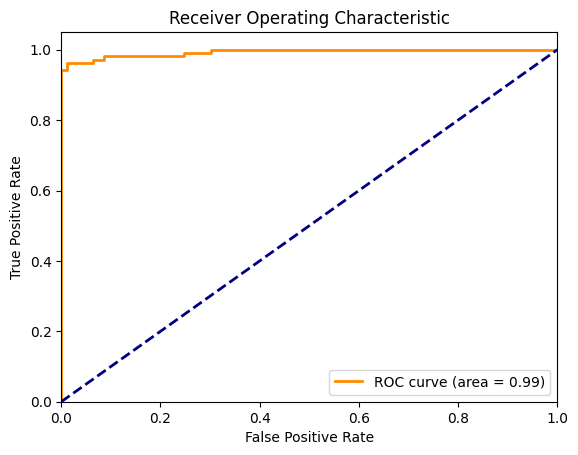

In [9]:
if __name__ == "__main__":
    main()